In [63]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Define the device

Determine material properties and geometry

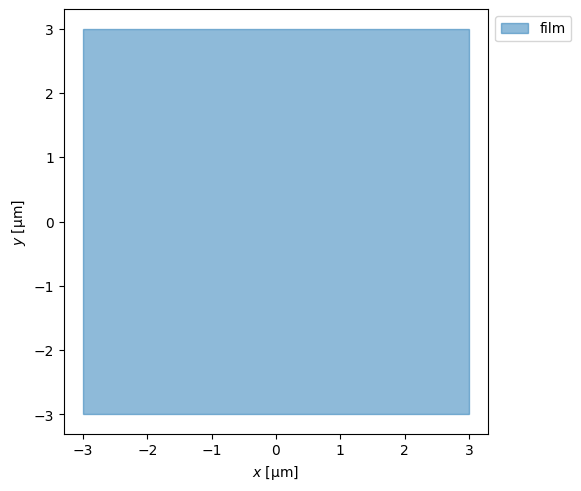

In [64]:
# Make Layer
length_units = 'um'

# Material parameters
xi = 1/3
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 6
total_length = 6

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    length_units=length_units,
)

fig, ax = device.draw()

Finite Volume Method

Constructing Voronoi polygons: 100%|██████████| 4733/4733 [00:01<00:00, 2586.89it/s]


num_sites,4733
num_elements,9064
min_edge_length,3.888e-02
max_edge_length,1.568e-01
mean_edge_length,9.490e-02
min_area,8.159e-04
max_area,1.631e-02
mean_area,7.606e-03
coherence_length,3.333e-01
length_units,um


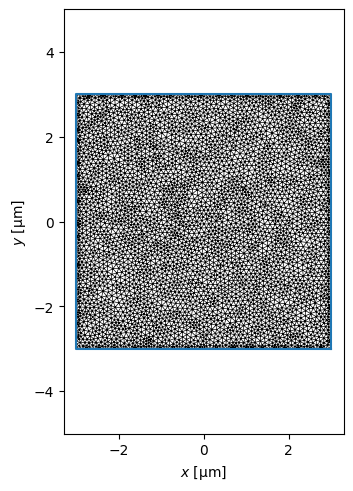

In [65]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

# Simulation Options

Define some functions

In [66]:
# plot the time dependency of magnetic field
def plot_time_factor(t_step, B_list, field_unit):
    N = len(B_list)
    t_list = np.arange((N+1)*t_step, step=t_step)
    for i in range(N):
        ti = t_list[i]
        tf = t_list[i+1]
        t = np.linspace(ti, tf, 10)
        B = B_list[i] * np.ones_like(t)
        plt.plot(t, B, c = 'b')
    #plt.plot(t_list, B_list)
    plt.ylabel('B/{unit}'.format(unit=field_unit))
    plt.xlabel('Time/s')
    plt.show()

Field options

Here I am going to define an external magnetic field whose strength increases and decreases in a stair-like manner over time.  
t_step: time to stay on each stage  
B_max: maximum magnetic field of the stair  
N: numbers of sampling points during ramp up and ramp down, 2*N altogether

In [67]:
t_step = 300
B_max = 2.0 
N = 20
B_up = np.linspace(0, B_max, N)
B_down = np.linspace(B_max, 0, N)
B_list = np.concatenate((B_up, B_down))

Solver options

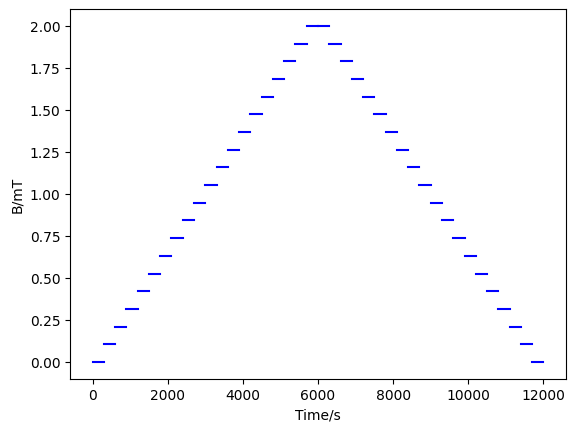

In [68]:
options = tdgl.SolverOptions(
    skip_time=0,
    solve_time=t_step,
    save_every=100,
    field_units="mT",
    output_file=os.path.join('solutions/0822/hysterisis_3', "I-B.h5"),
)
plot_time_factor(t_step, B_list, 'mT')

# Simulation

Since at each stage the applied field is constant, we can save the time by simulating each stage successively rather than simulating them as a whole. This method can make simulation faster but will create more simulation files.

In [69]:
from pint import Quantity

K_list = np.zeros_like(B_list)
K_list = Quantity(K_list, 'microampere/micrometer')

for step in range(len(B_list)):
    b_z = B_list[step]
    field = tdgl.sources.ConstantField(b_z, field_units=options.field_units, length_units=device.length_units)
    if step == 0:
        solution = tdgl.solve(device, options, applied_vector_potential=b_z)
    else:
        solution = tdgl.solve(device, options, applied_vector_potential=b_z, seed_solution=solution)
    '''
    device.mesh.boundary_indices get sites on boundary
    use sites as index for solution.supercurrent_density
    and use l2 norm and take average
    '''
    K_list[step] = np.average(np.linalg.norm(solution.supercurrent_density[device.mesh.boundary_indices], axis=1))

Simulating: 100%|█████████▉| 300/300 [00:04<00:00, 62.59tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-1.h5.
Simulating: 100%|█████████▉| 300/300 [00:09<00:00, 30.80tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-2.h5.
Simulating: 100%|█████████▉| 300/300 [00:09<00:00, 30.35tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-3.h5.
Simulating: 100%|█████████▉| 300/300 [00:11<00:00, 25.52tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-4.h5.
Simulating: 100%|█████████▉| 300/300 [00:17<00:00, 17.24tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-5.h5.
Simulating: 100%|█████████▉| 300/300 [00:09<00:00, 32.21tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-6.h5.
Simulating: 100%|█████████▉| 300/300 [00:13<00:00, 22.07tau/s ]
Output file already exists. Renaming to solutions/0822/hysterisis_3\I-B-7.h5.
Simula

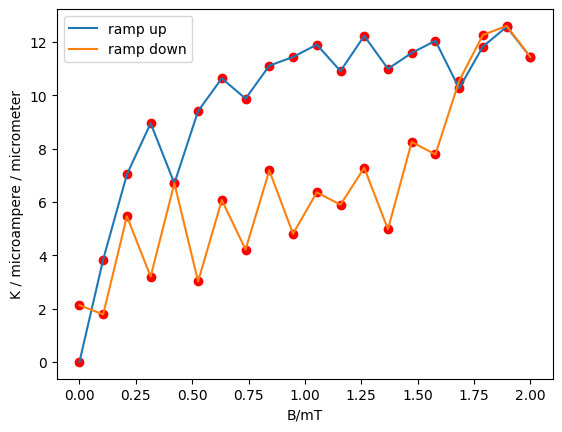

In [70]:
def plot_I_B(B_up, B_down, K_list, field_unit):
    plt.plot(B_up, K_list[:len(B_up)].magnitude, label='ramp up')
    plt.plot(B_down, K_list[len(B_up):].magnitude, label='ramp down')
    plt.scatter(B_list, K_list.magnitude, c='r')
    plt.legend()
    plt.ylabel('K / {unit}'.format(unit=K_list.units))
    plt.xlabel('B/{unit}'.format(unit=field_unit))

plot_I_B(B_up, B_down, K_list, options.field_units)